In [30]:
import pandas as pd 
from prophet import Prophet
import matplotlib.pyplot as plt
import pickle


In [2]:
df_clean = pd.read_pickle('../data/processed/df_processed.pkl')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  object 
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
dtypes: float64(10), int64(3), object(2)
memory usage: 51.5+ MB


In [ ]:
# Reassigning Date as a column
if "Date" not in df_clean.columns and df_clean.index.name == 'Date':
    df_clean.reset_index(inplace=True)

In [5]:
# data renaming as required by prophet
df_prophet = df_clean[['Date', 'Weekly_Sales']].rename(columns={
    'Date' : 'ds',
    'Weekly_Sales' : 'y'
})

In [7]:
df_performanceerformanceerformanceerformancerophet = df_prophet[df_clean['Store']==1] #Selecting a single store

display(df_prophet.head())

,ds,y
0,2010-02-05,24924.50
698,2010-02-05,11501.46
706,2010-02-05,814.00
709,2010-02-05,70.00
712,2010-02-05,1.16


### Initialize/Fit/Predict

In [26]:
#Initializing Prophet
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                weekly_seasonality=True)

# Fitting the model to the data
model.fit(df_prophet)

# creating a future dataframe with 52 weeks
future = model.make_future_dataframe(periods=52, freq='W')

# creating a forecast
forecast = model.predict(future)

print('Forecast Generated, Displaying the Final rows:')
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing


Forecast Generated, Displaying the Final rows:


,ds,yhat,yhat_lower,yhat_upper
190,2013-09-22,22549.096283,-12698.528295,58916.668958
191,2013-09-29,22867.274183,-13330.656143,58430.493665
192,2013-10-06,23226.003115,-12412.599562,57084.812863
193,2013-10-13,23142.280880,-11914.598951,60153.870420
194,2013-10-20,22744.450234,-13049.866347,56826.577711


### Forecast Visuals

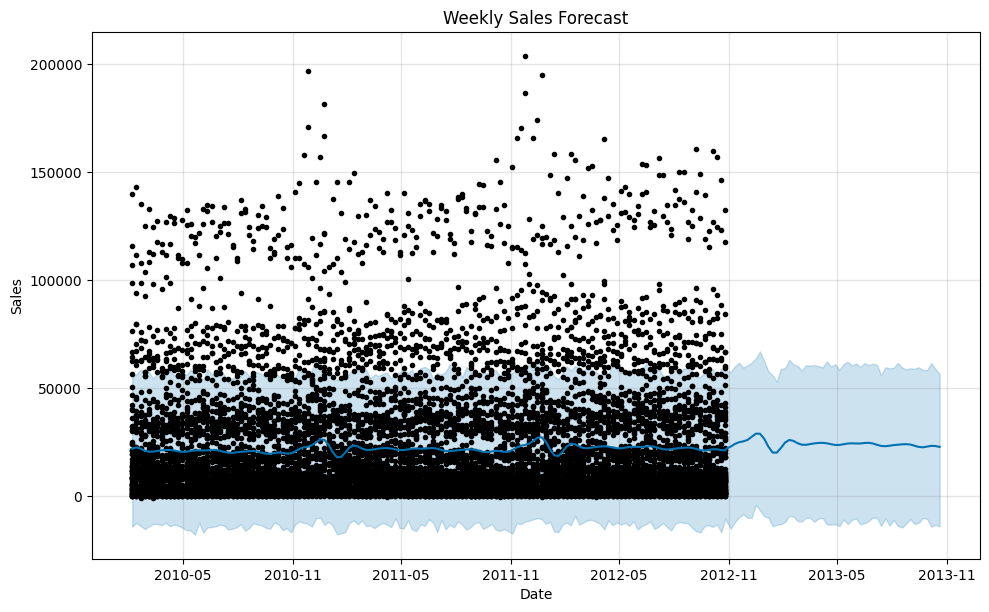

In [10]:
fig1 = model.plot(forecast)
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

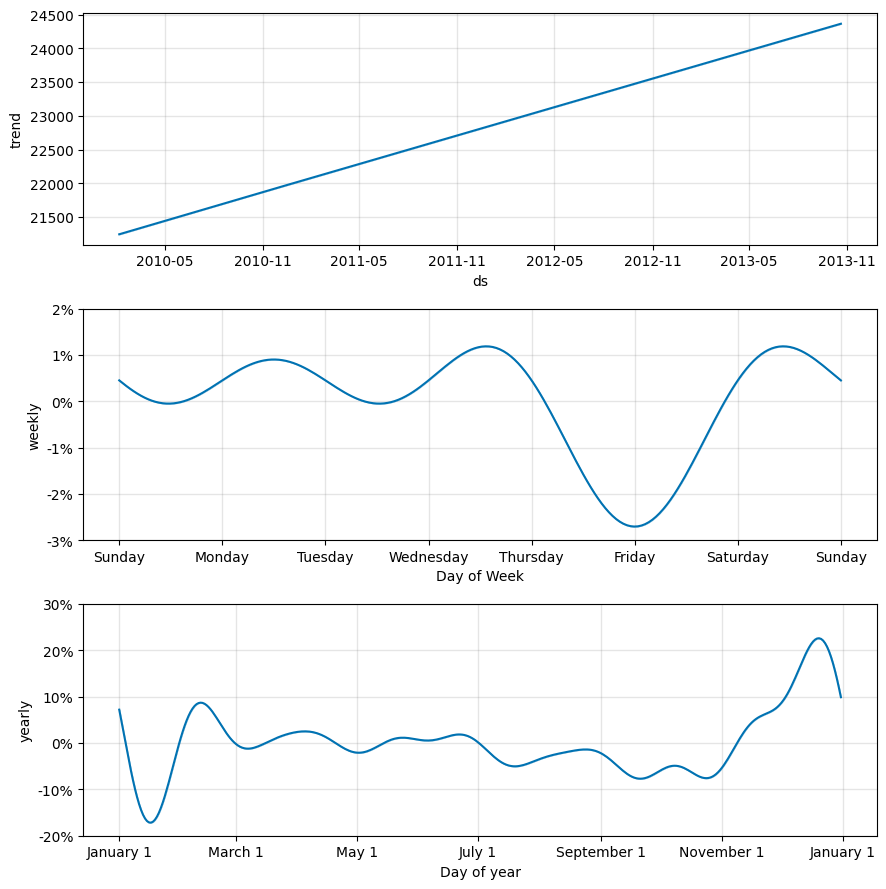

In [11]:
fig2 = model.plot_components(forecast)
plt.show()

### Prophet Cross Validation

In [13]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# --- Perform Cross-Validation ---
# initial: The size of the first training period (e.g., 730 days = 2 years)
# period: The spacing between cutoff dates (e.g., 180 days = 6 months)
# horizon: The forecast horizon we want to test (e.g., 365 days = 1 year)
df_crossval = cross_validation(model, initial='547 days', period='90 days', horizon='180 days', parallel="processes") # Ensuring the sum initial + horizon fit within the datasets timeframe (1001 days long)

# Display the first few rows of the cross-validation results
# 'y' is the actual value, 'yhat' is the prediction for that point in time.
display(df_crossval.head())

15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing
15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:27 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-11-04,20739.799953,-13293.536338,55826.710689,19041.07,2011-11-01
1,2011-11-04,20739.799953,-13698.334852,53881.043479,47313.62,2011-11-01
2,2011-11-04,20739.799953,-14569.520575,56190.593508,6223.03,2011-11-01
3,2011-11-04,20739.799953,-15332.485906,54974.583945,9079.08,2011-11-01
4,2011-11-04,20739.799953,-14437.654345,54993.265061,4357.48,2011-11-01


In [14]:
# --- Calculate Performance Metrics ---
df_performance = performance_metrics(df_crossval)
display(df_performance.head())

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,8.871700e+08,29785.398709,21160.101303,59.635095,1.141356,0.994515,0.877240
1,19 days,8.759872e+08,29597.080959,21014.413663,59.073825,1.125529,0.986905,0.882119
2,24 days,9.523797e+08,30860.649191,21358.617593,51.866416,1.072300,0.980495,0.883790
3,25 days,9.280594e+08,30464.068017,21153.401047,28.059290,1.068005,0.977720,0.885305
4,26 days,9.066725e+08,30111.003712,21074.360030,45.879349,1.022839,0.979013,0.885894


/workspaces/sales-forecast/venv/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/workspaces/sales-forecast/venv/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


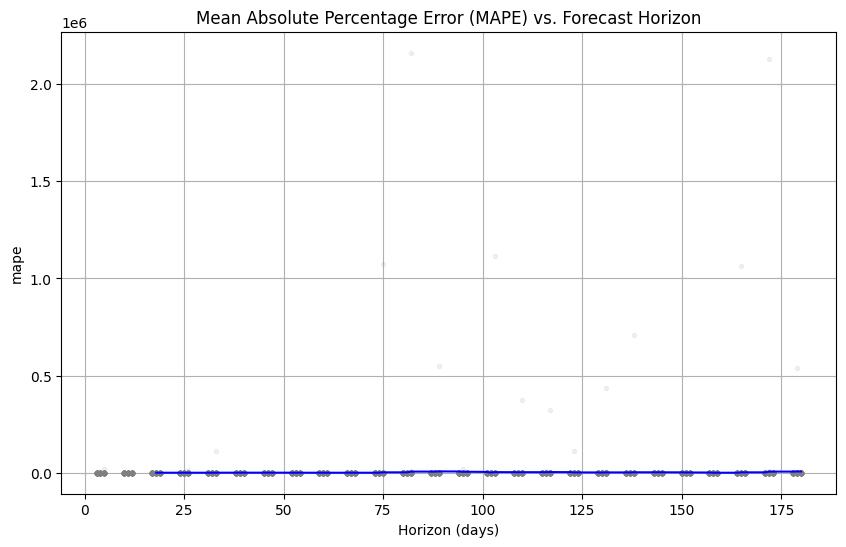

In [15]:
# --- Visualize a key metric (e.g., MAPE) ---
fig = plot_cross_validation_metric(df_crossval, metric='mape')
plt.title('Mean Absolute Percentage Error (MAPE) vs. Forecast Horizon')
plt.show()

In [31]:
with open ('../src/prophet_model_store1.pkl', 'wb') as f:
    pickle.dump(model, f)

print('Prophet model for Store1 has been trained and saved to src.')

Prophet model for Store1 has been trained and saved to src.
